# Parameter identification example

Here is a simple toy model that we use to demonstrate the working of the inference package

$\emptyset \xrightarrow[]{k_1} X \; \; \; \; X \xrightarrow[]{d_1} \emptyset$


In [14]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

In [2]:
%matplotlib inline
import bioscrape as bs
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model
from bioscrape.pid_interfaces import *
from bioscrape.emcee_interface import *
import numpy as np
import pylab as plt
import pandas as pd
M = Model('toy_model.xml')

# Generate experimental data
1. Simulate bioscrape model
2. Add Gaussian noise of non-zero mean and non-zero variance to the simulation
3. Create appropriate Pandas dataframes 
4. Write the data to a CSV file

In [3]:
timepoints = np.linspace(0,20,100)
result = py_simulate_model(timepoints, Model = M)['X']

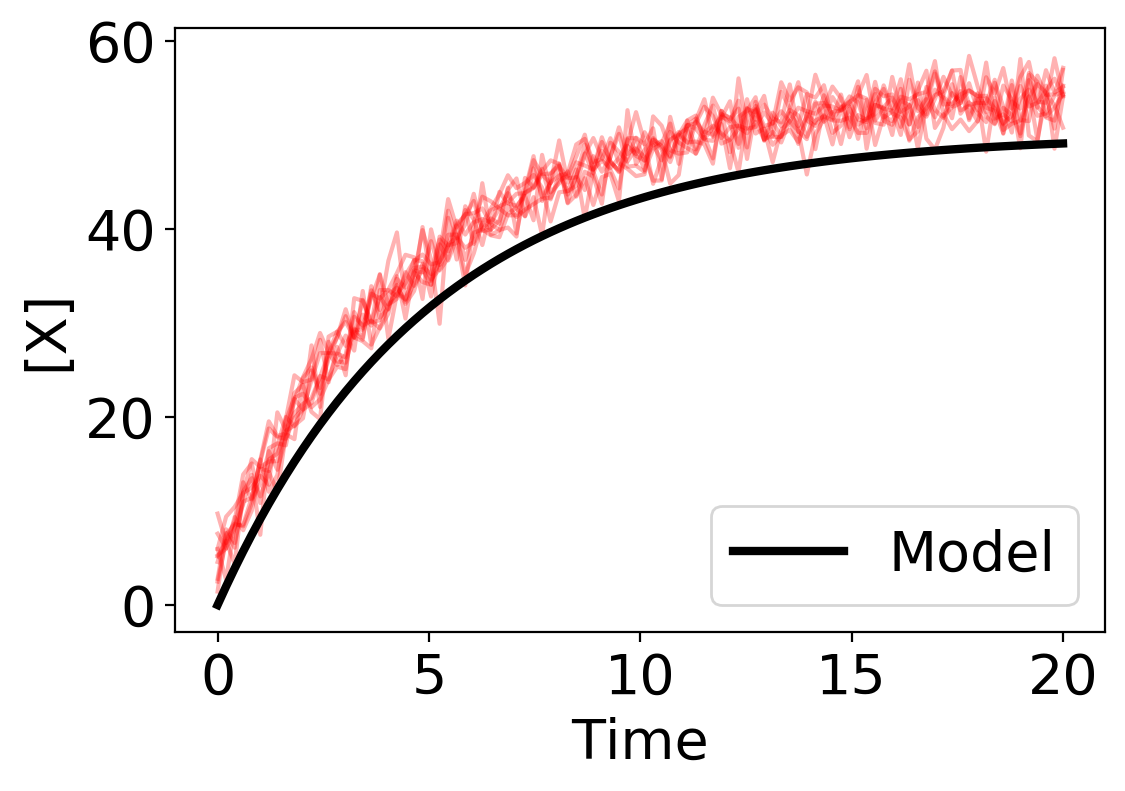

In [15]:
num_trajectories = 10
exp_data = pd.DataFrame()
exp_data['timepoints'] = timepoints
for i in range(num_trajectories):
    exp_data['X' + str(i)] = result + np.random.normal(5, 2, size = np.shape(result))
    plt.plot(timepoints, exp_data['X' + str(i)], 'r', alpha = 0.3)
plt.plot(timepoints, result, 'k', linewidth = 3, label = 'Model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('[X]')
plt.show()


## CSV looks like:


In [5]:
exp_data.to_csv('birth_death_data.csv')
exp_data

timepoints         X0         X1         X2         X3         X4  \
0     0.000000   4.226855   6.757244   6.416227   1.655895   4.101605   
1     0.202020   8.582267   6.049244   8.531431   8.665428   6.751410   
2     0.404040  11.055659  10.530778  11.239175   8.015078   7.156605   
3     0.606061   9.842694  12.151628  12.083782   9.866032  11.542132   
4     0.808081  12.258396  10.881336  12.559596  11.376411  13.031105   
..         ...        ...        ...        ...        ...        ...   
95   19.191919  56.268410  53.281969  55.301041  52.908377  55.790897   
96   19.393939  53.811322  56.383353  52.349013  55.985724  54.330643   
97   19.595960  57.102831  54.408598  54.038945  47.773294  56.956130   
98   19.797980  54.209270  55.460330  55.073324  51.343184  51.042895   
99   20.000000  54.362077  54.961918  54.384192  53.481893  56.390772   

           X5         X6         X7         X8         X9  
0    3.938917   5.139271   6.480671   3.782608   4.989476  
1    6.627429   5.846906   7.028328   3.073195   6.482691  
2    9.061713  10.067125  11.920860  10.224268   6.282902  
3    9.120111  11.129891  13.983138   8.603738  12.066694  
4    8.798668  11.061696  12.154693   7.402585  15.443598  
..        ...        ...        ...        ...        ...  
95  54.940941  55.566653  54.205002  54.513487  54.337363  
96  55.724022  55.234298  56.055154  55.596544  50.735527  
97  53.807035  55.319239  52.671086  53.756561  53.808994  
98  57.806321  50.623883  53.880194  50.906671  54.455258  
99  56.752923  54.266843  54.376015  54.241114  53.304370  

[100 rows x 11 columns]

# Run the bioscrape MCMC algorithm to identify parameters from the experimental data 

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [10:04<00:00,  6.61it/s]


Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file
Parameter posterior distribution convergence plots:


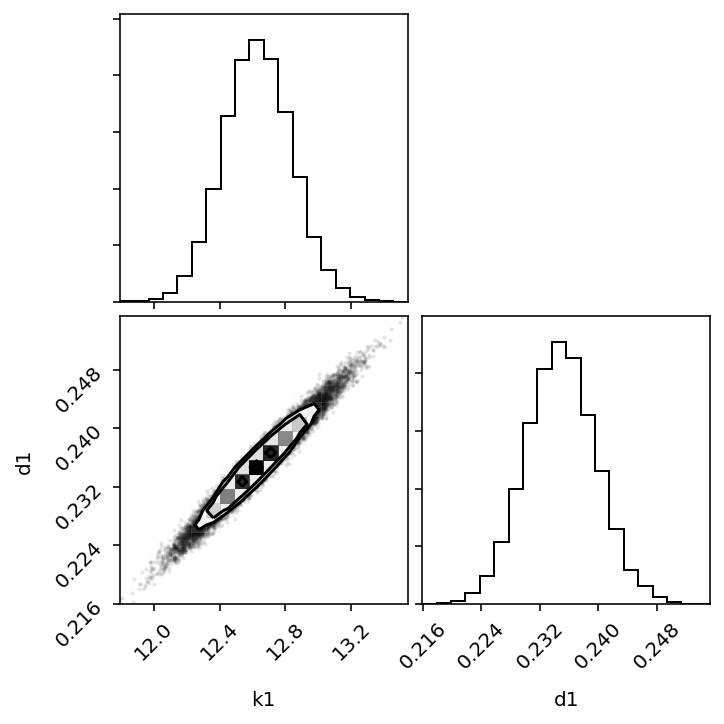

In [7]:

pid = initialize_mcmc(Model = M)

# Import data from CSV
# Import a CSV file for each experiment run
exp_data = []
for i in range(num_trajectories):
    df = pd.read_csv('birth_death_data.csv', usecols = ['timepoints', 'X'+str(i)])
    df.columns = ['timepoints', 'X']
    exp_data.append(df)

pid.set_exp_data(exp_data)
# pid.set_exp_data(list_of_dfs)
pid.set_measurements(['X'])
pid.set_time_column(['timepoints'])
pid.set_params_to_estimate(['k1','d1'])
pid.set_nwalkers(100)
pid.set_init_seed(0.15)
pid.set_nsteps(4000)
pid.set_sim_type('deterministic')

# Higher the probability threshold, you have wider priors. 
# Allowing lower probabilities with lower threshold implies stricter priors.
# prior = {'d1' : ['gaussian', 0, 10, 1e-3], 'k1' : ['gaussian', 0, 50, 1e-4]}
prior = {'k1' : ['uniform', 0, 100],'d1' : ['uniform',0,10]}
# prior = {'d1' : ['uniform', 0, 20]}
pid.set_prior(prior)

sampler = pid.run_mcmc(plot_show = True)
pid.plot_mcmc_results(sampler);

In [16]:
pid.plot_mcmc_results(sampler);

Parameter posterior distribution convergence plots:


### Check mcmc_results.csv for the results of the MCMC procedure and perform your own analysis.

# OR

### You can also plot the results as follows

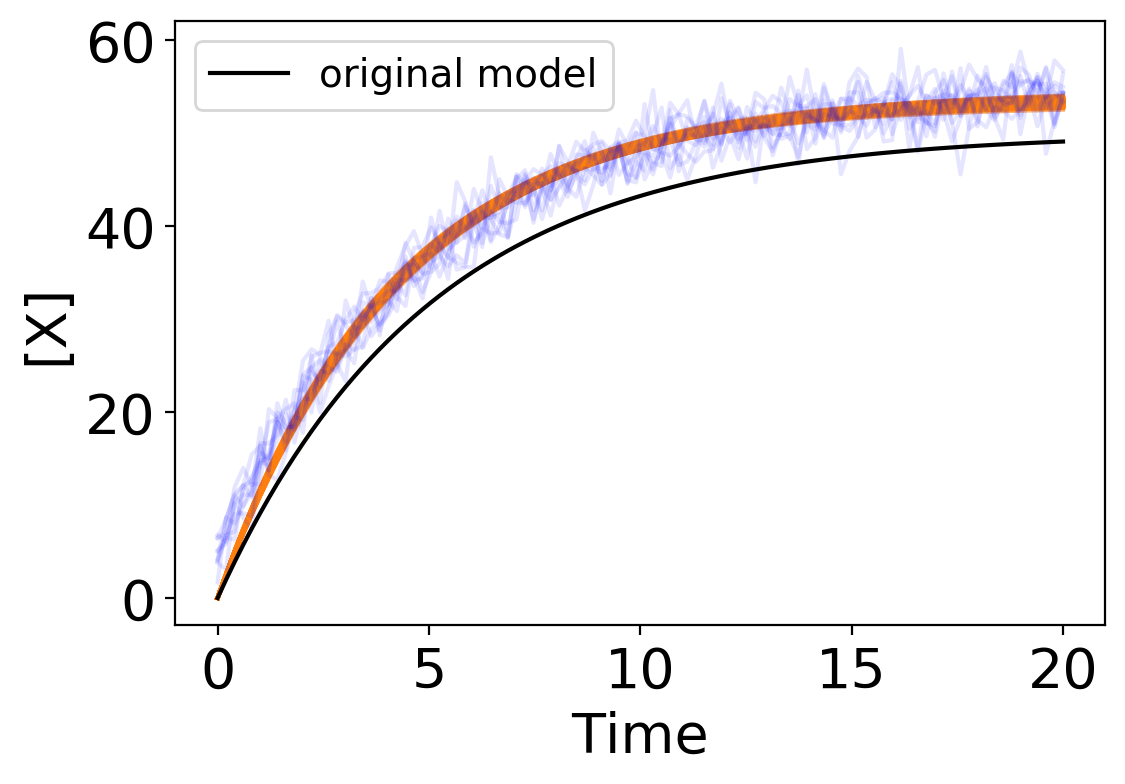

In [20]:
M_fit = Model('toy_model.xml')
timepoints = pid.timepoints[0]
flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)
inds = np.random.randint(len(flat_samples), size=200)
for ind in inds:
    sample = flat_samples[ind]
    for pi, pi_val in zip(pid.params_to_estimate, sample):
        M_fit.set_parameter(pi, pi_val)
    plt.plot(timepoints, py_simulate_model(timepoints, Model= M_fit)['X'], "C1", alpha=0.6)
# plt.errorbar(, y, yerr=yerr, fmt=".k", capsize=0)
for i in range(num_trajectories):
    plt.plot(timepoints, list(pid.exp_data[i]['X']), 'b', alpha = 0.1)
plt.plot(timepoints, result, "k", label="original model")
plt.legend(fontsize=14)
plt.xlabel("Time")
plt.ylabel("[X]");

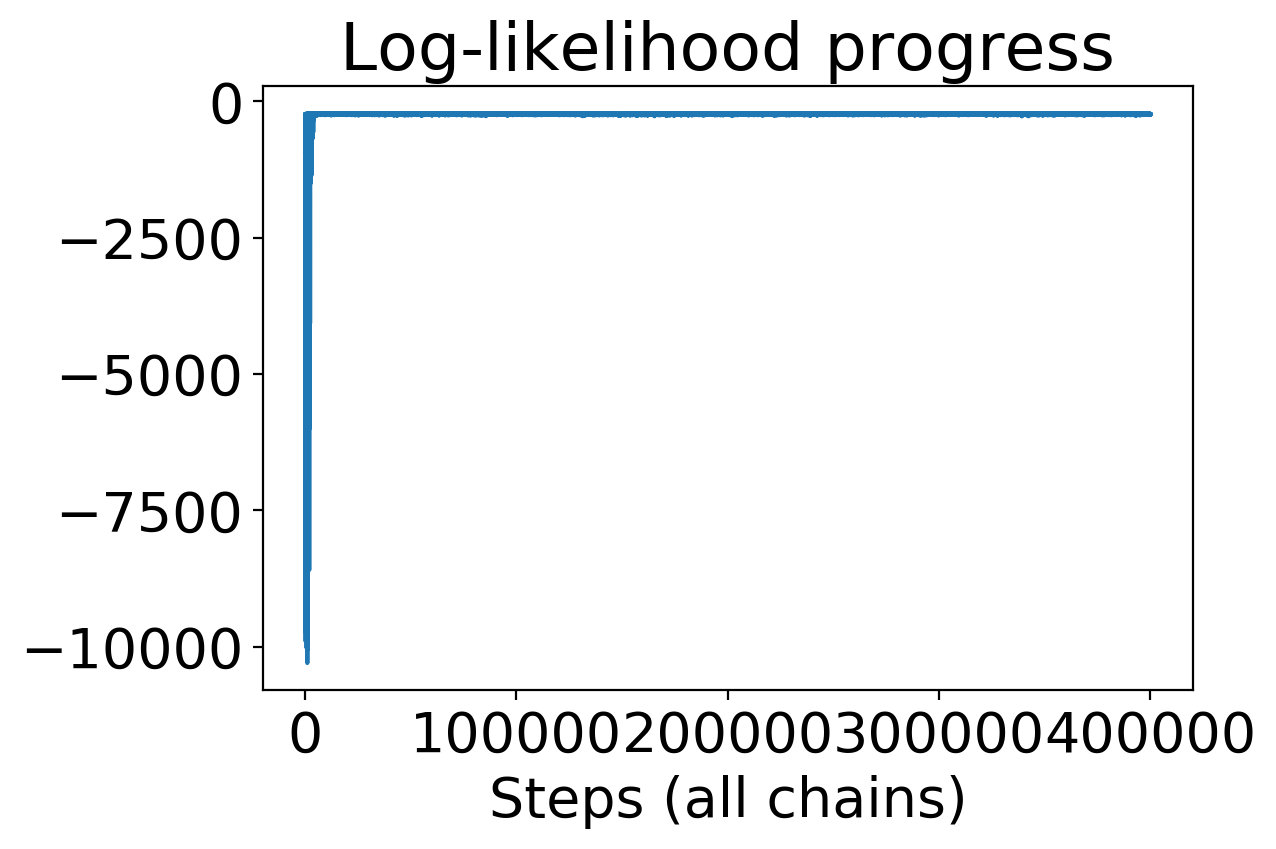

In [21]:
plt.close()
plt.title('Log-likelihood progress')
plt.plot(pid.cost_progress)
plt.xlabel('Steps (all chains)')
plt.show()

## Alll methods above have other advanced options that you can use. Refer to Parameter Identification Tools and Advanced Examples notebook for more details. There are many other tools available such as for multiple initial conditions and timepoints for each trajectory, options for the estimator etc.